In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
tp_bound = 111994
predict_max_index = 185223

In [3]:
training_data_df = pd.read_csv('training_data.csv', index_col = [0])
predict_data_df = pd.read_csv('predict_data.csv', index_col = [0])

In [4]:
# rid of N/A values and 0 values and outliers???
training_data_df = training_data_df.dropna()
training_data_df = training_data_df.drop(training_data_df[training_data_df['Gender'] == '0'].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['University Degree'] == '0'].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Hair Color'] == '0'].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Income'] > 2000000].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Income'] <= 0 ].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Body Height [cm]'] < 100].index)
training_data_df = training_data_df.drop(training_data_df[training_data_df['Body Height [cm]'] > 250].index)

training_data_df.shape

(89048, 11)

In [5]:
(train_bound, col) = training_data_df.shape
training_data_df.head()

,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income
Instance,,,,,,,,,,,
2,1996.0,other,41.0,Singapore,1603504,safe event coordinator,Master,0,Black,186,91001.32764
3,2018.0,other,28.0,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170,157982.17670
4,2006.0,other,33.0,Cuba,751903,fleet assistant,No,1,Black,171,45993.75793
6,1991.0,male,60.0,Liberia,56080,senior security analyst,Bachelor,0,Blond,181,125809.99030
9,2015.0,male,43.0,South Sudan,85333,intergovernmental outreach coordinator,No,0,Blond,189,48058.20607


In [6]:
total_data_df = pd.concat([training_data_df, predict_data_df])
total_data_df.head()

,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income
Instance,,,,,,,,,,,
2,1996.0,other,41.0,Singapore,1603504,safe event coordinator,Master,0,Black,186,91001.32764
3,2018.0,other,28.0,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170,157982.17670
4,2006.0,other,33.0,Cuba,751903,fleet assistant,No,1,Black,171,45993.75793
6,1991.0,male,60.0,Liberia,56080,senior security analyst,Bachelor,0,Blond,181,125809.99030
9,2015.0,male,43.0,South Sudan,85333,intergovernmental outreach coordinator,No,0,Blond,189,48058.20607


In [7]:
# column N/A values
total_data_df.shape[0] - total_data_df.count()

Year of Record         295
Gender                4862
Age                    279
Country                  0
Size of City             0
Profession             195
University Degree     4857
Wears Glasses            0
Hair Color            4916
Body Height [cm]         0
Income               73230
dtype: int64

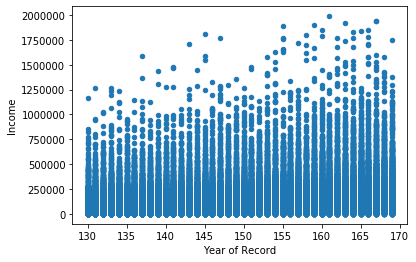

In [8]:
total_data_df['Year of Record'].fillna(2000, inplace = True)
total_data_df['Year of Record'] = total_data_df['Year of Record'].map(lambda year: year - 1850)

total_data_df[:tp_bound].plot.scatter(x='Year of Record', y = 'Income')

In [9]:
total_data_df['Gender'].fillna('unknown', inplace = True)
total_data_df['Gender'].replace('0', 'unknown', inplace = True)

total_data_df['Gender'].value_counts().sort_index()

female     40955
male       65017
other      40804
unknown    15502
Name: Gender, dtype: int64

In [10]:
gender_dummies = pd.get_dummies(total_data_df['Gender'], prefix = 'Gender')
total_data_df.drop('Gender', axis = 1, inplace = True)
total_data_df = total_data_df.join(gender_dummies)
total_data_df.drop('Gender_unknown', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,Gender_other
Instance,,,,,,,,,,,,,
2,146.0,41.0,Singapore,1603504,safe event coordinator,Master,0,Black,186,91001.32764,0,0,1
3,168.0,28.0,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170,157982.17670,0,0,1
4,156.0,33.0,Cuba,751903,fleet assistant,No,1,Black,171,45993.75793,0,0,1
6,141.0,60.0,Liberia,56080,senior security analyst,Bachelor,0,Blond,181,125809.99030,0,1,0
9,165.0,43.0,South Sudan,85333,intergovernmental outreach coordinator,No,0,Blond,189,48058.20607,0,1,0


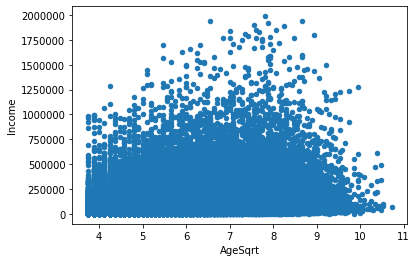

In [11]:
total_data_df['Age'].fillna(35, inplace=True)
total_data_df['AgeSqrt'] = total_data_df['Age'].map(lambda a: np.sqrt(a))
total_data_df.drop('Age', axis = 1, inplace = True)
total_data_df[:train_bound].plot.scatter(x='AgeSqrt', y = 'Income')

In [12]:
total_data_df['Country'].fillna('unknown', inplace = True)
dummies = pd.get_dummies(total_data_df['Country'], prefix = 'Country')
total_data_df.drop('Country', axis = 1, inplace = True)
total_data_df = total_data_df.join(dummies)

total_data_df.head()

,Year of Record,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,...,Country_Ukraine,Country_United Arab Emirates,Country_United Kingdom,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela,Country_Yemen,Country_Zambia,Country_Zimbabwe
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,1603504,safe event coordinator,Master,0,Black,186,91001.32764,0,0,...,0,0,0,0,0,0,0,0,0,0
3,168.0,1298017,receivables/payables analyst,PhD,1,Brown,170,157982.17670,0,0,...,0,0,0,0,0,0,0,0,0,0
4,156.0,751903,fleet assistant,No,1,Black,171,45993.75793,0,0,...,0,0,0,0,0,0,0,0,0,0
6,141.0,56080,senior security analyst,Bachelor,0,Blond,181,125809.99030,0,1,...,0,0,0,0,0,0,0,0,0,0
9,165.0,85333,intergovernmental outreach coordinator,No,0,Blond,189,48058.20607,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:

total_data_df['SoC_8e6_1'] = total_data_df['Size of City'].map(lambda soc: soc if soc < 8e6 else 0)
total_data_df['SoC_8e6_2'] = total_data_df['Size of City'].map(lambda soc: soc if soc > 8e6 else 0)


In [14]:
total_data_df['SoC_8e6_1'] = total_data_df['Size of City'].map(lambda soc: soc if soc < 8e6 else 0)
total_data_df['SoC_8e6_2'] = total_data_df['Size of City'].map(lambda soc: soc if soc > 8e6 else 0)
total_data_df.drop('Size of City', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,Gender_other,...,Country_United Kingdom,Country_Uruguay,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela,Country_Yemen,Country_Zambia,Country_Zimbabwe,SoC_8e6_1,SoC_8e6_2
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,safe event coordinator,Master,0,Black,186,91001.32764,0,0,1,...,0,0,0,0,0,0,0,0,1603504,0
3,168.0,receivables/payables analyst,PhD,1,Brown,170,157982.17670,0,0,1,...,0,0,0,0,0,0,0,0,1298017,0
4,156.0,fleet assistant,No,1,Black,171,45993.75793,0,0,1,...,0,0,0,0,0,0,0,0,751903,0
6,141.0,senior security analyst,Bachelor,0,Blond,181,125809.99030,0,1,0,...,0,0,0,0,0,0,0,0,56080,0
9,165.0,intergovernmental outreach coordinator,No,0,Blond,189,48058.20607,0,1,0,...,0,0,0,0,0,0,0,0,85333,0


In [15]:
total_data_df['Profession'].fillna('unknown', inplace = True)
dummies = pd.get_dummies(total_data_df['Profession'], prefix = 'P')
total_data_df.drop('Profession', axis = 1, inplace = True)
total_data_df = total_data_df.join(dummies)
total_data_df.drop('P_unknown', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,University Degree,Wears Glasses,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,Gender_other,AgeSqrt,...,P_windows administrator,P_wireless coordinator,P_woodworker,P_word processor,P_workforce management analyst,P_workforce planning intern,P_writer,P_x-ray technician,P_yardmaster,P_youth initiatives lead advisor
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,Master,0,Black,186,91001.32764,0,0,1,6.403124,...,0,0,0,0,0,0,0,0,0,0
3,168.0,PhD,1,Brown,170,157982.17670,0,0,1,5.291503,...,0,0,0,0,0,0,0,0,0,0
4,156.0,No,1,Black,171,45993.75793,0,0,1,5.744563,...,0,0,0,0,0,0,0,0,0,0
6,141.0,Bachelor,0,Blond,181,125809.99030,0,1,0,7.745967,...,0,0,0,0,0,0,0,0,0,0
9,165.0,No,0,Blond,189,48058.20607,0,1,0,6.557439,...,0,0,0,0,0,0,0,0,0,0


In [16]:
total_data_df['University Degree'].fillna('unknown', inplace = True)
total_data_df['University Degree'].replace('0', 'unknown', inplace = True)
dummies = pd.get_dummies(total_data_df['University Degree'], prefix = 'UD')
total_data_df.drop('University Degree', axis = 1, inplace = True)
total_data_df = total_data_df.join(dummies)
total_data_df.drop('UD_unknown', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,Wears Glasses,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,Gender_other,AgeSqrt,Country_Afghanistan,...,P_workforce management analyst,P_workforce planning intern,P_writer,P_x-ray technician,P_yardmaster,P_youth initiatives lead advisor,UD_Bachelor,UD_Master,UD_No,UD_PhD
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,0,Black,186,91001.32764,0,0,1,6.403124,0,...,0,0,0,0,0,0,0,1,0,0
3,168.0,1,Brown,170,157982.17670,0,0,1,5.291503,0,...,0,0,0,0,0,0,0,0,0,1
4,156.0,1,Black,171,45993.75793,0,0,1,5.744563,0,...,0,0,0,0,0,0,0,0,1,0
6,141.0,0,Blond,181,125809.99030,0,1,0,7.745967,0,...,0,0,0,0,0,0,1,0,0,0
9,165.0,0,Blond,189,48058.20607,0,1,0,6.557439,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
# dummies = pd.get_dummies(total_data_df['Wears Glasses'], prefix = 'WG')
# total_data_df.drop('Wears Glasses', axis = 1, inplace = True)
# total_data_df = total_data_df.join(dummies)

# drop glasses
total_data_df.drop('Wears Glasses', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,Hair Color,Body Height [cm],Income,Gender_female,Gender_male,Gender_other,AgeSqrt,Country_Afghanistan,Country_Albania,...,P_workforce management analyst,P_workforce planning intern,P_writer,P_x-ray technician,P_yardmaster,P_youth initiatives lead advisor,UD_Bachelor,UD_Master,UD_No,UD_PhD
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,Black,186,91001.32764,0,0,1,6.403124,0,0,...,0,0,0,0,0,0,0,1,0,0
3,168.0,Brown,170,157982.17670,0,0,1,5.291503,0,0,...,0,0,0,0,0,0,0,0,0,1
4,156.0,Black,171,45993.75793,0,0,1,5.744563,0,0,...,0,0,0,0,0,0,0,0,1,0
6,141.0,Blond,181,125809.99030,0,1,0,7.745967,0,0,...,0,0,0,0,0,0,1,0,0,0
9,165.0,Blond,189,48058.20607,0,1,0,6.557439,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
# total_data_df['Hair Color'].fillna('unknown', inplace = True)
# total_data_df['Hair Color'].replace('0', 'unknown', inplace = True)
# dummies = pd.get_dummies(total_data_df['Hair Color'], prefix = 'HC')
# total_data_df.drop('Hair Color', axis = 1, inplace = True)
# total_data_df = total_data_df.join(dummies)
# total_data_df.drop('HC_unknown', axis = 1, inplace = True)

# drop hair
total_data_df.drop('Hair Color', axis = 1, inplace = True)

total_data_df.head()

,Year of Record,Body Height [cm],Income,Gender_female,Gender_male,Gender_other,AgeSqrt,Country_Afghanistan,Country_Albania,Country_Algeria,...,P_workforce management analyst,P_workforce planning intern,P_writer,P_x-ray technician,P_yardmaster,P_youth initiatives lead advisor,UD_Bachelor,UD_Master,UD_No,UD_PhD
Instance,,,,,,,,,,,,,,,,,,,,,
2,146.0,186,91001.32764,0,0,1,6.403124,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,168.0,170,157982.17670,0,0,1,5.291503,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,156.0,171,45993.75793,0,0,1,5.744563,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,141.0,181,125809.99030,0,1,0,7.745967,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,165.0,189,48058.20607,0,1,0,6.557439,0,0,0,...,0,0,0,0,0,0,0,0,1,0


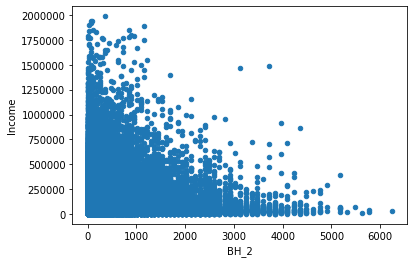

In [19]:
total_data_df['BH_2'] = total_data_df['Body Height [cm]'].map(lambda bh: (180 - bh)**2)
total_data_df.drop('Body Height [cm]', axis = 1, inplace = True)
total_data_df[:train_bound].plot.scatter(x='BH_2', y = 'Income')

In [25]:
# training

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

total = total_data_df.drop('Income', axis = 1, inplace = False)
X = total[: train_bound]
y = total_data_df[: train_bound]['Income'].map(lambda y: np.sqrt(np.abs(y)))

linreg1 = LinearRegression()
# rfReg = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None)

# KFlod
# kfold = KFold(n_splits=20, random_state=None, shuffle=True)
# results_arr = []
# iii = 0
# for train_index, test_index in kfold.split(X):
#     print(iii, ':')
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.values[train_index], X.values[test_index]
#     y_train, y_test = y.values[train_index], y.values[test_index]
#     linreg1 = LinearRegression()
#     linreg1.fit(X_train, y_train)
#     score = linreg1.score(X_test, y_test)
#     print(score)
#     results_arr.append((linreg1, score))
#     iii += 1
    
# XGBoost
# xgb_model = xgb.XGBRegressor()
# params = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 0.5),
#     "learning_rate": uniform(0.03, 0.3), # default 0.1 
#     "max_depth": randint(2, 6), # default 3
#     "n_estimators": randint(100, 150), # default 100
#     "subsample": uniform(0.6, 0.4)
# }
# parameters = {'n_estimators': [120, 100, 140], 'max_depth':[3,5,7,9]}

# random search
# RSearch = RandomizedSearchCV(xgb_model,
#                              param_distributions=params,
#                              random_state=13,
#                              n_iter=200,
#                              cv=20,
#                              verbose=1,
#                              n_jobs=4,
#                              return_train_score=True)
# RSearch.fit(X.values, y.values)
# report_best_scores(RSearch.cv_results_, 1)

# grid_search = GridSearchCV(estimator=xgb_model, param_grid=parameters, cv=10, n_jobs=-1)
# grid_search.fit(X.values, y.values)
# best_parameters=grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

linreg1.fit(X_train, y_train)
print(linreg1.score(X_test, y_test))
y_pred = linreg1.predict(X_test)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# rfReg.fit(X_train, y_train)
# rfReg.score(X_test, y_test)

0.8571374280775004
The rmse of prediction is: 62.06864017607172


In [34]:
# lightgbm
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, 
    'early_stopping_round': 20}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                1000,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
                
print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

ValueError: Found input variables with inconsistent numbers of samples: [89048, 73230]

In [31]:
x = total[train_bound: ]
# (linreg1, _) = results_arr[4]
# y = linreg1.predict(x)
# y = rfReg.predict(x)
y = gbm.predict(x, num_iteration=gbm.best_iteration)

In [32]:
income_series = pd.Series(y, name = 'Income')
instance_series = pd.Series(np.arange(tp_bound, predict_max_index + 1), name = 'Instance')
result = pd.concat([instance_series, income_series], axis = 1)
result['Income'] = result['Income'].map(lambda y: y**2)
result.to_csv('result-6.csv', index = False)